[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Linear_Regression_scVI.ipynb)

In [1]:
import os
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scvi

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.linear_model 
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from rat_friend import *

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/utils.py:429: FutureWar

In [2]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Initial Data Loading

In [3]:
og_adata = anndata.read_h5ad("/home/coakes/rat/omics_adata/rat_RNA_meta.h5ad")

og_adata.obs.time = og_adata.obs.time.astype('int')

# normalized but not logged due to the meathematical assumptions underlying linear regression 
sc.pp.normalize_total(og_adata)

og_adata.layers["counts"] = og_adata.X.copy()
og_adata

AnnData object with n_obs × n_vars = 861 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

# scVI Latent Space Generation

In [4]:
X, y, z = data_reshaper_omic(og_adata, tiss_list = og_adata.obs.tissue.unique())
reshaped_adata = anndata.AnnData(X, obs = y, var = z)
scvi.model.SCVI.setup_anndata(reshaped_adata
)
scvi_ref = scvi.model.SCVI(reshaped_adata,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True)
scvi_ref.train()
latent = scvi_ref.get_latent_representation()

SKM-GN
HYPOTH
CORTEX
HIPPOC
WAT
BAT
BLOOD
SPLEEN
SMLINT
COLON
ADRNL
KIDNEY
SKM-VL
HEART
LIVER
LUNG


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True


Training:   0%|          | 0/400 [00:00<?, ?it/s]

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/scvi/module/_vae.py:569: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/coakes/miniconda3/

# Linear Regression on Latent Space

In [5]:
X = latent
y = reshaped_adata.obs.reset_index(drop=True)

np.random.seed(0)

train_filter = y[['nid', 'time', 'sex']].groupby('nid',observed=False).agg(lambda x: x.value_counts().index[0])
train_nids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(3)).index.get_level_values(2).tolist()
ref_mask = [x in train_nids for x in y.nid]

X_train = X[ref_mask]
X_test = X[list(~np.array(ref_mask))]
y_train = y[ref_mask]
y_test = y[list(~np.array(ref_mask))]

# instantiate the model (using the default parameters)
model = sklearn.linear_model.Ridge(random_state=0)

# fit the model with data
model.fit(X_train, y_train.time)

y_pred = model.predict(X_test)

latent_ccc = get_CCC(y_test.time.astype('int'), y_pred)

test_df = pd.DataFrame({'prediction' : y_pred,
                            'actual' : y_test.time,
                            'Sex': y_test.sex
                             })
test_df.index = y_test.nid
test_df['Subset'] = 'test'
train_df = pd.DataFrame({'prediction' : model.predict(X_train),
                            'actual' : y_train.time,
                            'Sex': y_train.sex
                             })
train_df.index = y_train.nid
train_df['Subset'] = 'train'

/tmp/ipykernel_1967399/475894449.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_nids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(3)).index.get_level_values(2).tolist()


# Graph Results

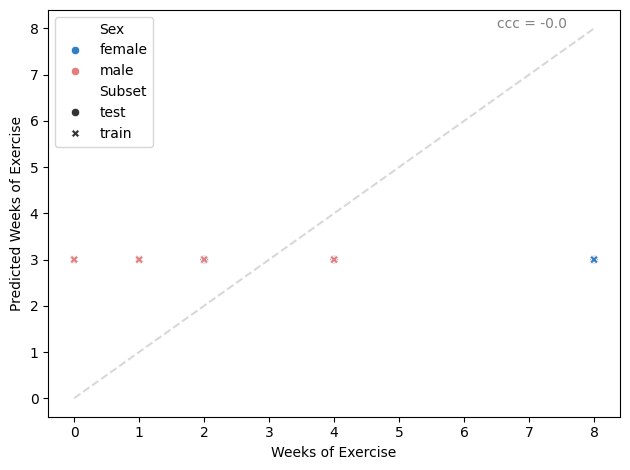

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(pd.concat([test_df, train_df]), x = 'actual', y = 'prediction', hue = 'Sex', style = 'Subset',
                   palette = color_dict)
plt.plot([0, 8], [0, 8], color = 'grey', alpha = .3, linestyle='--')
plt.text(6.5, 8, f'ccc = {round(latent_ccc, 3)}', c = 'grey')
plt.tight_layout()
plt.xlabel('Weeks of Exercise')
plt.ylabel('Predicted Weeks of Exercise')
plt.savefig('figures_final/supp_fig_7.png')
plt.show()